<a href="https://colab.research.google.com/github/chanhobong/earlyGA/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup Environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.1 MB/s eta 0:00:00


In [ ]:
import logging
import os
import sys
import shutil
import tempfile

import matplotlib.pyplot as plt
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np

import monai
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import DataLoader, ImageDataset
from monai.transforms import (
    EnsureChannelFirst,
    Compose,
    RandRotate90,
    Resize,
    ScaleIntensity,
)

pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
print_config()

MONAI version: 1.3.dev2334
Numpy version: 1.23.5
Pytorch version: 2.0.1+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c5771c7316c8b024071ecd7135d77ae70bcd557e
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
scipy version: 1.10.1
Pillow version: 9.4.0
Tensorboard version: 2.12.3
gdown version: 4.6.6
TorchVision version: 0.15.2+cu118
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 1.5.3
einops version: 0.6.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit

### Setup data directory

In [ ]:
root_dir='/content/drive/MyDrive/Disertation/Project2/classification-dataset-v1'
save_dir = '/content/drive/MyDrive/Disertation/Project2/best_file'
print(root_dir)
os.chdir(root_dir)
print(save_dir)
os.chdir(save_dir)

/content/drive/MyDrive/Disertation/Project2/classification-dataset-v1
/content/drive/MyDrive/Disertation/Project2/best_file


In [ ]:
images = [
    os.sep.join([root_dir,'early-presto0016.nii.gz' ]),
    os.sep.join([root_dir,'early-presto0019.nii.gz' ]),
    os.sep.join([root_dir,'early-presto0041.nii.gz' ]),
    os.sep.join([root_dir,'early-presto0052.nii.gz' ]),
    os.sep.join([root_dir,'early-presto0054.nii.gz' ]),
    os.sep.join([root_dir,'early-presto0066.nii.gz' ]),
    os.sep.join([root_dir,'early-presto0068.nii.gz' ]),
    os.sep.join([root_dir,'early-presto0072.nii.gz' ]),
    os.sep.join([root_dir,'early-presto0075.nii.gz' ]),
    os.sep.join([root_dir,'early-presto0078.nii.gz' ]),
    os.sep.join([root_dir,'early-presto0080.nii.gz' ]),
    os.sep.join([root_dir,'early-presto0082.nii.gz' ]),

    os.sep.join([root_dir,'med-presto0005.nii.gz' ]),
    os.sep.join([root_dir,'med-presto0006.nii.gz' ]),
    os.sep.join([root_dir,'med-presto0015.nii.gz' ]),
    os.sep.join([root_dir,'med-presto0020.nii.gz' ]),
    os.sep.join([root_dir,'med-presto0022.nii.gz' ]),
    os.sep.join([root_dir,'med-presto0034.nii.gz' ]),
    os.sep.join([root_dir,'med-presto0036.nii.gz' ]),
    os.sep.join([root_dir,'med-presto0051.nii.gz' ]),
    os.sep.join([root_dir,'med-presto0071.nii.gz' ]),
    os.sep.join([root_dir,'med-presto0074.nii.gz' ]),
    os.sep.join([root_dir,'med-presto0093.nii.gz' ]),
    os.sep.join([root_dir,'med-presto004702.nii.gz' ]),

    os.sep.join([root_dir,'late-presto0001.nii.gz' ]),
    os.sep.join([root_dir,'late-presto0003.nii.gz' ]),
    os.sep.join([root_dir,'late-presto0009.nii.gz' ]),
    os.sep.join([root_dir,'late-presto0024.nii.gz' ]),
    os.sep.join([root_dir,'late-presto0039.nii.gz' ]),
    os.sep.join([root_dir,'late-presto0046.nii.gz' ]),
    os.sep.join([root_dir,'late-presto0049.nii.gz' ]),
    os.sep.join([root_dir,'late-presto0088.nii.gz' ]),
    os.sep.join([root_dir,'late-presto0091.nii.gz' ]),
    os.sep.join([root_dir,'late-presto0096.nii.gz' ]),
    os.sep.join([root_dir,'late-presto004703.nii.gz' ]),
    os.sep.join([root_dir,'late-presto006002.nii.gz' ]),
]


# 3 binary labels for early, late, med
labels = [
    0,  # early-presto0016.nii.gz
    0,  # early-presto0019.nii.gz
    0,  # early-presto0041.nii.gz
    0,  # early-presto0052.nii.gz
    0,  # early-presto0054.nii.gz
    0,  # early-presto0066.nii.gz
    0,  # early-presto0068.nii.gz
    0,  # early-presto0072.nii.gz
    0,  # early-presto0075.nii.gz
    0,  # early-presto0078.nii.gz
    0,  # early-presto0080.nii.gz
    0,  # early-presto0082.nii.gz

    1,  # med-presto0005.nii.gz
    1,  # med-presto0006.nii.gz
    1,  # med-presto0015.nii.gz
    1,  # med-presto0020.nii.gz
    1,  # med-presto0022.nii.gz
    1,  # med-presto0034.nii.gz
    1,  # med-presto0036.nii.gz
    1,  # med-presto0051.nii.gz
    1,  # med-presto0071.nii.gz
    1,  # med-presto0074.nii.gz
    1,  # med-presto0093.nii.gz
    1,  # med-presto004702.nii.gz

    2,  # late-presto0001.nii.gz
    2,  # late-presto0003.nii.gz
    2,  # late-presto0009.nii.gz
    2,  # late-presto0024.nii.gz
    2,  # late-presto0039.nii.gz
    2,  # late-presto0046.nii.gz
    2,  # late-presto0049.nii.gz
    2,  # late-presto0088.nii.gz
    2,  # late-presto0091.nii.gz
    2,  # late-presto0096.nii.gz
    2,  # late-presto004703.nii.gz
    2,  # late-presto006002.nii.gz
]

# Represent labels in one-hot format for binary classifier training,
# BCEWithLogitsLoss requires target to have same shape as input
labels = torch.nn.functional.one_hot(torch.as_tensor(labels)).float()

# Check the dataset

Num of total image : 36
Image Path: /content/drive/MyDrive/Disertation/Project2/classification-dataset-v1/early-presto0016.nii.gz
Label: tensor([1., 0., 0.])


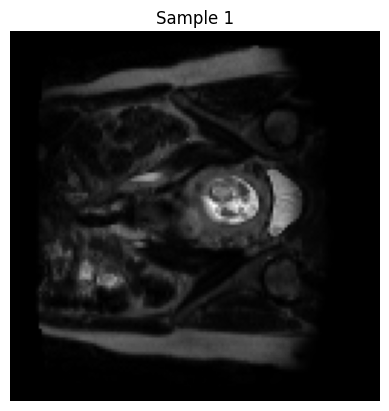

Image Path: /content/drive/MyDrive/Disertation/Project2/classification-dataset-v1/med-presto0005.nii.gz
Label: tensor([0., 1., 0.])


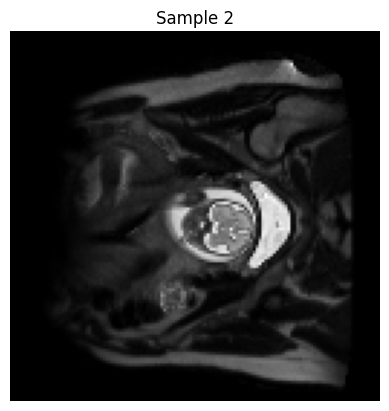

Image Path: /content/drive/MyDrive/Disertation/Project2/classification-dataset-v1/late-presto0001.nii.gz
Label: tensor([0., 0., 1.])


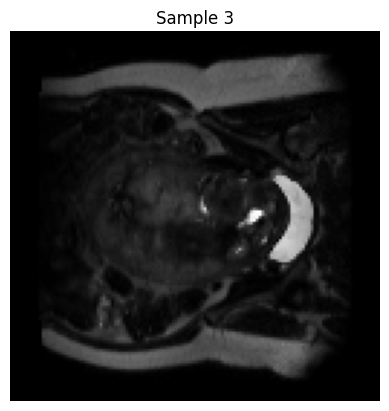

In [ ]:
import nibabel as nib
data_size = len(images)
print('Num of total image :', data_size)

for i in range(3):
    image_path = images[i*12]
    label = labels[i*12]
    print(f"Image Path: {image_path}")
    print(f"Label: {label}")

    # 이미지 로드
    image = nib.load(image_path)
    image_data = image.get_fdata()

    # 이미지 시각화
    plt.imshow(image_data[:, :, 65], cmap="gray")  # 예시로 슬라이스 50을 시각화
    plt.title(f"Sample {i+1}")
    plt.axis("off")
    plt.show()

# Build Train and Validataion

In [ ]:
# Define transforms
train_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(), Resize((96, 96, 96)), RandRotate90()])
val_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(), Resize((96, 96, 96))])

# Define nifti dataset, data loader
check_ds = ImageDataset(image_files=images, labels=labels, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=3, num_workers=2, pin_memory=pin_memory)
im, label = monai.utils.misc.first(check_loader)
# device = im.device

print(type(im))
print('image shape:',im.shape)
print('label: \n', label)
print('label shape:', label.shape)

# create a training data loader
train_ds = ImageDataset(image_files=images[:10], labels=labels[:10], transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2, pin_memory=pin_memory)

# create a validation data loader
import random

# Shuffle the dataset
random.seed(42)  # Set a seed for reproducibility
combined_data = list(zip(images, labels))
random.shuffle(combined_data)
images, labels = zip(*combined_data)

# Calculate the number of samples for train, validation, and test sets
total_samples = len(images)
train_samples = int(total_samples * 0.7)
val_samples = int(total_samples * 0.3)


# Split the dataset into train, validation, and test sets
train_images = images[:train_samples]
train_labels = labels[:train_samples]
val_images = images[train_samples:train_samples+val_samples]
val_labels = labels[train_samples:train_samples+val_samples]


# Create train, validation, and test datasets and data loaders
train_ds = ImageDataset(image_files=train_images, labels=train_labels, transform=train_transforms)
val_ds = ImageDataset(image_files=val_images, labels=val_labels, transform=val_transforms)


train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2, pin_memory=pin_memory)
val_loader = DataLoader(val_ds, batch_size=2, num_workers=2, pin_memory=pin_memory)


<class 'monai.data.meta_tensor.MetaTensor'>
image shape: torch.Size([3, 1, 96, 96, 96])
label: 
 tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]])
label shape: torch.Size([3, 3])


RESNET Network

In [ ]:
import torch
import torch.nn as nn

class BottleNeck3D(nn.Module):
    def __init__(self, in_dim, mid_dim, out_dim, activation, down=False):
        super(BottleNeck3D, self).__init__()
        self.down = down

        if self.down:
            self.layer = nn.Sequential(
                nn.Conv3d(in_dim, mid_dim, kernel_size=1, stride=2),
                nn.BatchNorm3d(mid_dim),
                activation,
                nn.Conv3d(mid_dim, mid_dim, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm3d(mid_dim),
                activation,
                nn.Conv3d(mid_dim, out_dim, kernel_size=1, stride=1),
                nn.BatchNorm3d(out_dim),
            )

            self.downsample = nn.Conv3d(in_dim, out_dim, kernel_size=1, stride=2)
        else:
            self.layer = nn.Sequential(
                nn.Conv3d(in_dim, mid_dim, kernel_size=1, stride=1),
                nn.BatchNorm3d(mid_dim),
                activation,
                nn.Conv3d(mid_dim, mid_dim, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm3d(mid_dim),
                activation,
                nn.Conv3d(mid_dim, out_dim, kernel_size=1, stride=1),
                nn.BatchNorm3d(out_dim),
            )

        self.dim_equalizer = nn.Conv3d(in_dim, out_dim, kernel_size=1)

    def forward(self, x):
        if self.down:
            downsample = self.downsample(x)
            out = self.layer(x)
            out = out + downsample
        else:
            out = self.layer(x)
            if x.size() is not out.size():
                x = self.dim_equalizer(x)
            out = out + x
        return out

class ResNet1523D(nn.Module):
    def __init__(self, num_classes=3):
        super(ResNet1523D, self).__init__()
        self.activation = nn.ReLU()
        self.layer_1 = nn.Sequential(
            nn.Conv3d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=3, stride=2, padding=1),
        )
        self.layer_2 = nn.Sequential(
            BottleNeck3D(64, 64, 256, self.activation),
            BottleNeck3D(256, 64, 256, self.activation),
            BottleNeck3D(256, 64, 256, self.activation),
        )
        self.layer_3 = nn.Sequential(
            BottleNeck3D(256, 128, 512, self.activation, down=True),
            BottleNeck3D(512, 128, 512, self.activation),
            BottleNeck3D(512, 128, 512, self.activation),
            BottleNeck3D(512, 128, 512, self.activation),
        )
        self.layer_4 = nn.Sequential(
            BottleNeck3D(512, 256, 1024, self.activation, down=True),
            BottleNeck3D(1024, 256, 1024, self.activation),
            BottleNeck3D(1024, 256, 1024, self.activation),
            BottleNeck3D(1024, 256, 1024, self.activation),
            BottleNeck3D(1024, 256, 1024, self.activation),
            BottleNeck3D(1024, 256, 1024, self.activation),
        )
        self.layer_5 = nn.Sequential(
            BottleNeck3D(1024, 512, 2048, self.activation, down=True),
            BottleNeck3D(2048, 512, 2048, self.activation),
            BottleNeck3D(2048, 512, 2048, self.activation),
        )
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc_layer = nn.Linear(2048, num_classes)

    def forward(self, x):
        out = self.layer_1(x)
        out = self.layer_2(out)
        out = self.layer_3(out)
        out = self.layer_4(out)
        out = self.layer_5(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc_layer(out)
        return out

# Instantiate the model
model = ResNet1523D()

# Print the model architecture
print(model)


ResNet1523D(
  (activation): ReLU()
  (layer_1): Sequential(
    (0): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer_2): Sequential(
    (0): BottleNeck3D(
      (layer): Sequential(
        (0): Conv3d(64, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1))
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): Conv3d(64, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1))
        (7): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (dim_equalizer): Conv3d(64,

In [ ]:
from monai.networks.nets import UNet, EfficientNet, ResNet ,DenseNet264
from monai.networks.blocks import ResBlock
from monai.networks.layers import Reshape
from torchvision.models import resnet152
from monai.networks.blocks import SEResNetBottleneck


# Create DenseNet121, CrossEntropyLoss and Adam optimizer
#model = monai.networks.nets.DenseNet264(spatial_dims=3, in_channels=1, out_channels=3).to(device)


model = ResNet1523D().to(device)


loss_function = torch.nn.CrossEntropyLoss()
#loss_function = torch.nn.BCEWithLogitsLoss()  # also works with this data

optimizer = torch.optim.Adam(model.parameters(), 1e-4)

# start a typical PyTorch training
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()
max_epochs = 1000


In [ ]:
def get_next_im():
    test_data = next(itera)
    print(test_data)
    return test_data[0].to(device), test_data[1].unsqueeze(0).to(device)


def plot_occlusion_heatmap(im, heatmap):
    plt.subplots(1, 2)
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(im.cpu()))
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap)
    plt.colorbar()
    plt.show()


In [ ]:
# classifier = model.to(device)

run_outputs = im.to(device)
# # ckpt_class = torch.load(os.path.join(save_dir, "Classification_DenseNet169.pth"), map_location=None)
# # classifier.load_state_dict(ckpt_class, strict=False)

# #logits_class = classifier(torch.softmax(run_outputs, dim=1))
# class_out = logits_class.argmax.tolist()  # Convert tensor to a Python list

run_outputs = run_outputs
batch_size = 1

logits_class = model(run_outputs).to(device)
class_out = logits_class.argmax(dim=1).tolist()





def convert_num_to_cond(x):
    if x == 0:
        z = "early"
    elif x == 1:
        z = "med"
    elif x == 2:
        z = "late"
    else:
        raise Exception("Not a valid label, should be an int between 0 and 2")
    return z

class_out = convert_num_to_cond(class_out[0])  # Assuming class_out is a single-element list
print('The predicted condition is = {}'.format(class_out))

classifier.to(device)
classifier.eval()


The predicted condition is = late


ResNet2(
  (activation): ReLU()
  (layer_1): Sequential(
    (0): Conv3d(3, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer_2): Sequential(
    (0): BottleNeck(
      (layer): Sequential(
        (0): Sequential(
          (0): Conv3d(64, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (1): Sequential(
          (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (2): Sequential(
          (0): Conv3d(64, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1))
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
   

In [ ]:
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()

        num_correct = 0.0
        metric_count = 0
        for val_data in val_loader:
            val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
            with torch.no_grad():
                val_outputs = model(val_images)
                value = torch.eq(val_outputs.argmax(dim=1), val_labels.argmax(dim=1))
                metric_count += len(value)
                num_correct += value.sum().item()

                # calculate probability
                probabilities = torch.softmax(val_outputs, dim=1)
                # Final Prediction
                predictions = probabilities.argmax(dim=1)
                # Analysis predicted result
                predicted_classes = [convert_num_to_cond(pred.item()) for pred in predictions]


                for i in range(len(predicted_classes)):
                    print(f"Sample {i+1} prediction: {predicted_classes[i]}")

        metric = num_correct / metric_count
        metric_values.append(metric)

        if metric > best_metric:
            best_metric = metric
            best_metric_epoch = epoch + 1
            save_path = f"{save_dir}/Classification_CNN.pth"
            torch.save(model.state_dict(), save_path)
            print("Saved new best metric model at:", save_path)

        print(f"Current epoch: {epoch+1} current accuracy: {metric:.4f} ")
        print(f"Best accuracy: {best_metric:.4f} at epoch {best_metric_epoch}")
        writer.add_scalar("val_accuracy", metric, epoch + 1)

print(f"Training completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()


Streaming output truncated to the last 5000 lines.
epoch 774/1000
1/12, train_loss: -0.0000
2/12, train_loss: -0.0000
3/12, train_loss: -0.0000
4/12, train_loss: -0.0000
5/12, train_loss: -0.0000
6/12, train_loss: -0.0000
7/12, train_loss: -0.0000
8/12, train_loss: -0.0000
9/12, train_loss: -0.0000
10/12, train_loss: -0.0000
11/12, train_loss: -0.0000
12/12, train_loss: -0.0000
13/12, train_loss: -0.0000
epoch 774 average loss: 0.0000
Sample 1 prediction: late
Sample 2 prediction: late
Sample 1 prediction: med
Sample 2 prediction: early
Sample 1 prediction: med
Sample 2 prediction: early
Sample 1 prediction: late
Sample 2 prediction: med
Sample 1 prediction: late
Sample 2 prediction: early
Current epoch: 774 current accuracy: 0.8000 
Best accuracy: 1.0000 at epoch 136
----------
epoch 775/1000
1/12, train_loss: -0.0000
2/12, train_loss: -0.0000
3/12, train_loss: -0.0000
4/12, train_loss: -0.0000
5/12, train_loss: -0.0000
6/12, train_loss: -0.0000
7/12, train_loss: -0.0000
8/12, train_l

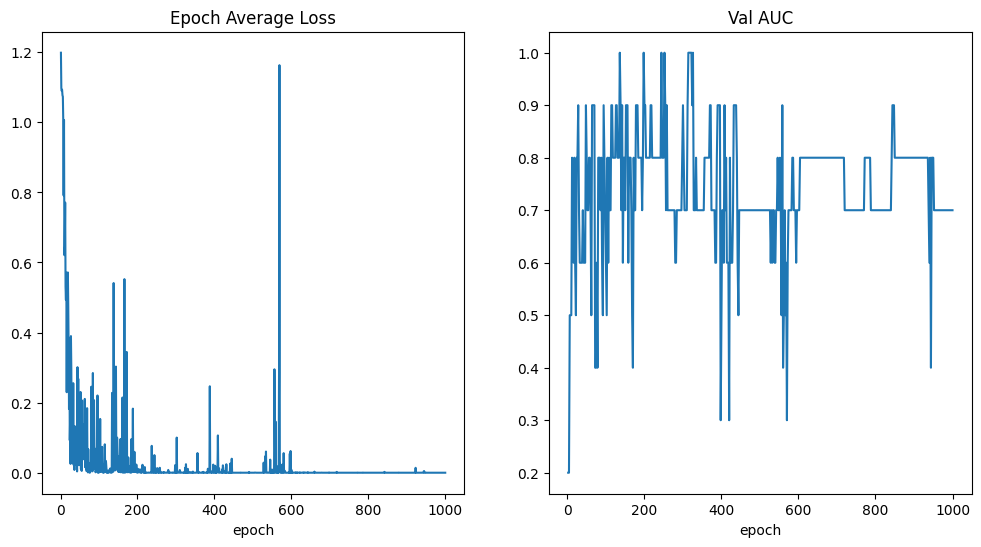

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [ ]:
# Define the path to the test dataset
test_dir = '/content/drive/MyDrive/Disertation/Project2/Test-dataset'

test_images = [
    os.sep.join([test_dir,'early-presto0086.nii.gz' ]),
    os.sep.join([test_dir,'early-presto0092.nii.gz' ]),
    os.sep.join([test_dir,'late-presto0099.nii.gz' ]),
    os.sep.join([test_dir,'late-presto0107.nii.gz' ]),
    os.sep.join([test_dir,'med-presto0095.nii.gz' ]),
    os.sep.join([test_dir,'med-presto0103.nii.gz' ])
    ]

test_labels = [
    0, # early-presto0086.nii.gz
    0, # early-presto0092.nii.gz
    2, # late-presto0099.nii.gz
    2, # late-presto0107.nii.gz
    1, # med-presto0095.nii.gz
    1  # med-presto0103.nii.gz
]

# Define transforms
test_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(), Resize((96, 96, 96))])

# Create the test dataset using ImageDataset
test_ds = ImageDataset(image_files=test_images, labels=test_labels, transform=test_transforms)

# Create the test data loader

test_loader = DataLoader(test_ds, batch_size=2, num_workers=2, pin_memory=True)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to get the next image tensor from the test loader
def get_next_im():
    test_data = next(iter(test_loader))
    return test_data.to(device)



In [ ]:
# Load Model 169

model = ResNet1523D().to(device)

loaded_model_state_dict = torch.load("/content/drive/MyDrive/Disertation/Project2/best_file/Classification_ResNet152.pth")
loaded_model = model.to(device)
loaded_model.load_state_dict(loaded_model_state_dict)
loaded_model.eval()

# Test set
test_predictions = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data  # Unpack the test_data tuple
        test_images = test_images.to(device)  # Assuming the test_data is already 3D
        test_outputs = loaded_model(test_images)

        # Transform predicted index class to label
        predicted_labels = test_outputs.argmax(dim=1)
        predicted_classes = [convert_num_to_cond(pred.item()) for pred in predicted_labels]
        true_classes = [convert_num_to_cond(label.item()) for label in test_labels]  # Convert true labels to class names
        test_predictions.extend(zip(predicted_classes, true_classes))

# Print Final Prediction
print("Prediction Result:")
for i, (predicted, true_label) in enumerate(test_predictions):
    print(f"Sample {i+1} -- Prediction: {predicted} -- True Label: {true_label}")

from monai.metrics import ConfusionMatrixMetric

# Define the ConfusionMatrixMetric
confusion_metric = ConfusionMatrixMetric(
    include_background=True,
    metric_name=['recall', 'accuracy', 'precision', 'f1_score'],
    compute_sample=False,
    reduction="mean",
)

# Initialize variables to accumulate results
y_pred = []
y_true = []

# Set the model to evaluation mode

# Iterate through the test_loader and accumulate predictions and ground truth
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data  # Unpack the test_data tuple
        test_images = test_images.to(device)  # Assuming the test_data is already 3D
        test_outputs = loaded_model(test_images)

        # Convert predicted labels to one-hot format
        predicted_labels = test_outputs.argmax(dim=1).unsqueeze(1)
        predicted_one_hot = torch.nn.functional.one_hot(predicted_labels, num_classes=3)
        # Convert true labels to one-hot format
        true_labels_one_hot = torch.nn.functional.one_hot(test_labels.unsqueeze(1), num_classes=3)

        # Accumulate predictions and ground truth
        y_pred.append(predicted_one_hot)
        y_true.append(true_labels_one_hot)

# Convert y_pred and y_true to PyTorch Tensors
y_pred_val = torch.cat(y_pred, dim=0).to(device)
y_true_val = torch.cat(y_true, dim=0).to(device)

# Calculate the confusion matrix metric for the validation set
confusion_metric(y_pred=y_pred_val, y=y_true_val)

# Get the computed metrics for the validation set
metric_results = confusion_metric.aggregate()

recall = metric_results[0].item()
accuracy = metric_results[1].item()
precision = metric_results[2].item()
f1_score = metric_results[3].item()

# Print the computed metric results for each class
print("Confusion Matrix Metric Results:")
print("Recall:", round(recall,2))
print("Accuracy:", round(accuracy,2))
print("Precision:", round(precision,2))
print("F1 Score:", round(f1_score,2))

Prediction Result:
Sample 1 -- Prediction: med -- True Label: early
Sample 2 -- Prediction: early -- True Label: early
Sample 3 -- Prediction: late -- True Label: late
Sample 4 -- Prediction: late -- True Label: late
Sample 5 -- Prediction: med -- True Label: med
Sample 6 -- Prediction: late -- True Label: med
Confusion Matrix Metric Results:
Recall: 0.67
Accuracy: 0.78
Precision: 0.67
F1 Score: 0.67


In [ ]:
from monai.networks.nets.densenet import DenseNet169
# Load Model Densenet

model = monai.networks.nets.DenseNet169(spatial_dims=3, in_channels=1, out_channels=3).to(device)

loaded_model_state_dict = torch.load("/content/drive/MyDrive/Disertation/Project2/best_file/Classification_DenseNet169.pth")
loaded_model = model.to(device)
loaded_model.load_state_dict(loaded_model_state_dict)
loaded_model.eval()

# Test set
test_predictions = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data  # Unpack the test_data tuple
        test_images = test_images.to(device)  # Assuming the test_data is already 3D
        test_outputs = loaded_model(test_images)

        # Transform predicted index class to label
        predicted_labels = test_outputs.argmax(dim=1)
        predicted_classes = [convert_num_to_cond(pred.item()) for pred in predicted_labels]
        true_classes = [convert_num_to_cond(label.item()) for label in test_labels]  # Convert true labels to class names
        test_predictions.extend(zip(predicted_classes, true_classes))

# Print Final Prediction
print("Prediction Result:")
for i, (predicted, true_label) in enumerate(test_predictions):
    print(f"Sample {i+1} -- Prediction: {predicted} -- True Label: {true_label}")


from monai.metrics import ConfusionMatrixMetric

# Define the ConfusionMatrixMetric
confusion_metric = ConfusionMatrixMetric(
    include_background=True,
    metric_name=['recall', 'accuracy', 'precision', 'f1_score'],
    compute_sample=False,
    reduction="mean",
)

# Initialize variables to accumulate results
y_pred = []
y_true = []

# Iterate through the test_loader and accumulate predictions and ground truth
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data  # Unpack the test_data tuple
        test_images = test_images.to(device)  # Assuming the test_data is already 3D
        test_outputs = loaded_model(test_images)

        # Convert predicted labels to one-hot format
        predicted_labels = test_outputs.argmax(dim=1).unsqueeze(1)
        predicted_one_hot = torch.nn.functional.one_hot(predicted_labels, num_classes=3)
        # Convert true labels to one-hot format
        true_labels_one_hot = torch.nn.functional.one_hot(test_labels.unsqueeze(1), num_classes=3)

        # Accumulate predictions and ground truth
        y_pred.append(predicted_one_hot)
        y_true.append(true_labels_one_hot)

# Convert y_pred and y_true to PyTorch Tensors
y_pred_val = torch.cat(y_pred, dim=0).to(device)
y_true_val = torch.cat(y_true, dim=0).to(device)

# Calculate the confusion matrix metric for the validation set
confusion_metric(y_pred=y_pred_val, y=y_true_val)

# Get the computed metrics for the validation set
metric_results = confusion_metric.aggregate()

recall = metric_results[0].item()
accuracy = metric_results[1].item()
precision = metric_results[2].item()
f1_score = metric_results[3].item()

# Print the computed metric results for each class
print("Confusion Matrix Metric Results:")
print("Recall:", round(recall,2))
print("Accuracy:", round(accuracy,2))
print("Precision:", round(precision,2))
print("F1 Score:", round(f1_score,2))

Prediction Result:
Sample 1 -- Prediction: med -- True Label: early
Sample 2 -- Prediction: early -- True Label: early
Sample 3 -- Prediction: late -- True Label: late
Sample 4 -- Prediction: late -- True Label: late
Sample 5 -- Prediction: med -- True Label: med
Sample 6 -- Prediction: med -- True Label: med
Confusion Matrix Metric Results:
Recall: 0.83
Accuracy: 0.89
Precision: 0.83
F1 Score: 0.83
